In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NeuralNet, BayesianNN
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
from autograd import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

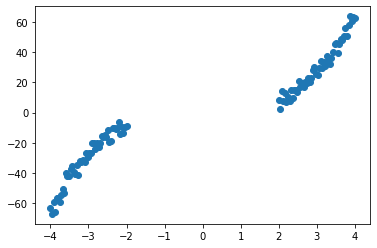

In [3]:
# Generate synthetic data
x, y, x_test = generate_data(number_of_points=50, noise_variance=9)

plt.scatter(x, y)
plt.show()

In [4]:
# Set up architecture for Bayesia neural network

activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50] # Use single layer to save computation time (same as the paper)
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
}

params = {
    'step_size': 5e-2,
    'max_iteration': 3000,
    'random_restarts': 1,
    'reg_param':1e-5
}


random = np.random.RandomState(207) #set random state to make the experiments replicable

# Initialize a Bayesian neural network
bnn = BayesianNN(architecture, random=random)

#fit Bayesian neural network to obtain MLE/MAP solution for weights
x_train = x.reshape((1, -1))
y_train = y.reshape((1, -1))
x_test = x_test.reshape((1, -1))

bnn.fit(x_train, y_train, params)


Iteration 0 loss 2420.3225914749996; gradient mag: 1554.8730576316332
Iteration 100 loss 84.17044415780514; gradient mag: 16.08901299761776
Iteration 200 loss 20.099453249329095; gradient mag: 6.458005843776142
Iteration 300 loss 11.881129250387232; gradient mag: 1.5053134006489937
Iteration 400 loss 10.555979478600584; gradient mag: 1.0409892636177929
Iteration 500 loss 9.84080402127391; gradient mag: 1.899205873304712
Iteration 600 loss 9.453984209991368; gradient mag: 0.49789464006786255
Iteration 700 loss 9.132865502388977; gradient mag: 1.1403147868624406
Iteration 800 loss 8.880081617831982; gradient mag: 0.46611361094987086
Iteration 900 loss 8.681567565467644; gradient mag: 1.5840875119622206
Iteration 1000 loss 8.525309636081179; gradient mag: 1.09723333897946
Iteration 1100 loss 8.375035185622593; gradient mag: 1.250008852789017
Iteration 1200 loss 8.26731231705272; gradient mag: 1.5123084413905123
Iteration 1300 loss 8.19825916259441; gradient mag: 1.744948230995326
Iteratio

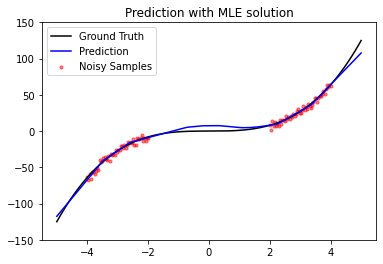

In [5]:
# visualize prediction on test data with MLE/MAP weights
y_test_pred = bnn.forward(bnn.weights, x_test)

plt.scatter(x,y, color='red', s = 10, alpha = 0.5, label="Noisy Samples")
plt.plot(x_test.flatten(), x_test.flatten()**3, color='black', label="Ground Truth")
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='blue', label="Prediction")
plt.ylim([-150, 150])
plt.title("Prediction with MLE solution")
plt.legend()
plt.show()

In [7]:
# Set up HMC parameters and perform sampling
HMC_param = {'step_size': 5e-3, 
             'leapfrog_steps': 60, 
             'total_samples': 5000, 
             'burn_in': 0.1, 
             'thinning_factor': 2}

noise_sd = 3.
prior_sd = 5.

bnn.sample_HMC(x_train, y_train, prior_sd = prior_sd, noise_sd = noise_sd, HMC_param = HMC_param)

print('Final accept =', bnn.accept)

Iteration 0, accept = 0.0


/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 100, accept = 0.8999999999991
Iteration 200, accept = 0.9049999999995476
Iteration 300, accept = 0.8999999999997
Iteration 400, accept = 0.8874999999997781
Iteration 500, accept = 0.8859999999998228
Iteration 600, accept = 0.8866666666665188
Iteration 700, accept = 0.8771428571427318
Iteration 800, accept = 0.8712499999998911
Iteration 900, accept = 0.8622222222221264
Iteration 1000, accept = 0.8529999999999147
Iteration 1100, accept = 0.853636363636286
Iteration 1200, accept = 0.843333333333263
Iteration 1300, accept = 0.8361538461537819
Iteration 1400, accept = 0.833571428571369
Iteration 1500, accept = 0.8273333333332782
Iteration 1600, accept = 0.8281249999999483
Iteration 1700, accept = 0.8252941176470102
Iteration 1800, accept = 0.8183333333332878
Iteration 1900, accept = 0.812105263157852
Iteration 2000, accept = 0.8079999999999595
Iteration 2100, accept = 0.8071428571428186
Iteration 2200, accept = 0.8045454545454179
Iteration 2300, accept = 0.8034782608695302
Iterati

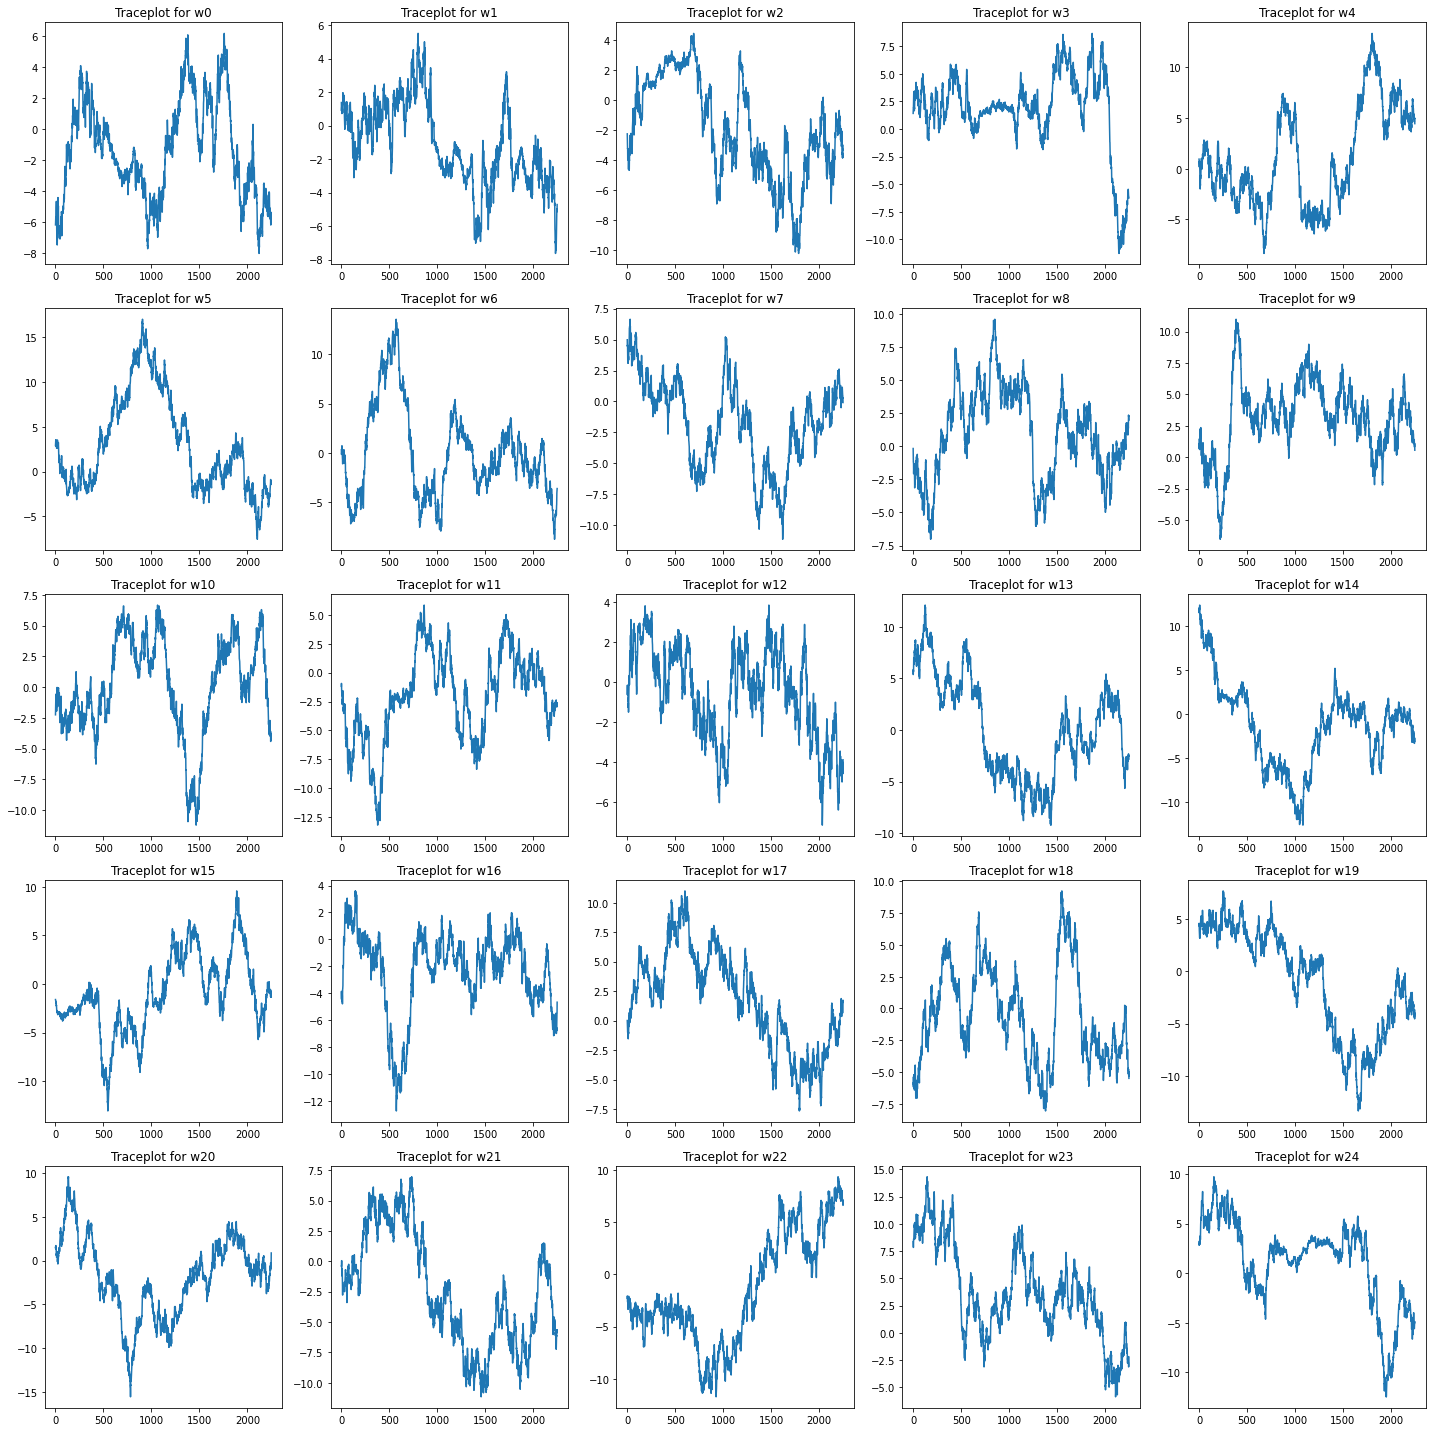

In [8]:
# Visualize some traceplots for diagnostics
fig, ax = plt.subplots(5,5,figsize = (20,20))
for i in range(25):
    ax[i//5,i%5].plot(bnn.thinned_trace[:,i])
    ax[i//5,i%5].set_title('Traceplot for w{}'.format(i))
plt.tight_layout()

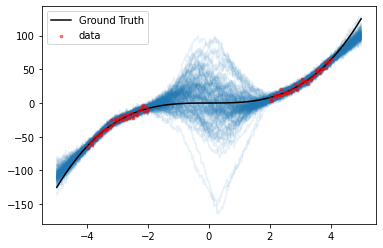

In [9]:
# Visualize posterior predictive
posterior_predictive = bnn.get_posterior_predictive(x_test)

plt.plot(x_test.T, posterior_predictive[np.random.choice(posterior_predictive.shape[0], size = 100, replace = False),:].T,color='tab:blue', alpha=0.1)
plt.scatter(x_train.flatten(), y_train.flatten(), s=7, color='r', alpha=0.5,label='data',zorder = 1000)
plt.plot(x_test.flatten(), x_test.flatten()**3, color='black', label="Ground Truth")
plt.legend(loc='best')
plt.show()

In [10]:
# Calulating percentiles
pp_upper = np.percentile(posterior_predictive, 97.5, axis=0)
pp_lower = np.percentile(posterior_predictive, 2.5, axis=0)
pp_upper2 = np.percentile(posterior_predictive, 84, axis=0)
pp_lower2 = np.percentile(posterior_predictive, 16, axis=0)
pp_mean = np.mean(posterior_predictive, axis=0)

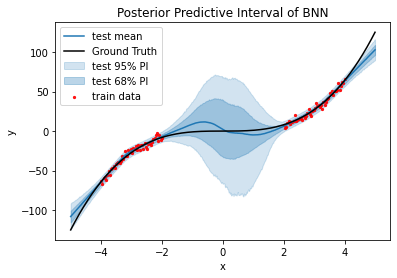

In [11]:
# Visualizing 95% posterior predictive interval 
plt.fill_between(x_test.flatten(), pp_upper, pp_lower, color = 'tab:blue', alpha = 0.2, label = 'test 95% PI')
plt.fill_between(x_test.flatten(), pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = 'test 68% PI')
plt.plot(x_test.flatten(), pp_mean, color = 'tab:blue', alpha = 1, label = 'test mean')
plt.plot(x_test.flatten(), x_test.flatten()**3, color='black', label="Ground Truth")
plt.scatter(x_train.flatten(), y_train.flatten(), s=5, color = "red", label = "train data", alpha = 0.9)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.title("Posterior Predictive Interval of BNN")
plt.show()

In [19]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
posterior_predictive = bnn.get_posterior_predictive(x_train)

print('Negative log likelihood on training data =', neg_log_likelihood(posterior_predictive, y_train, noise_sd**2))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(posterior_predictive))


Negative log likelihood on training data = 5.177603428529739
Epistemic uncertainty on training data =  3.1356285293217785


In [23]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = x_test_gap**3

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = x_test_non_gap**3

posterior_predictive_gap = bnn.get_posterior_predictive(x_test_gap)
posterior_predictive_non_gap = bnn.get_posterior_predictive(x_test_non_gap)

print('Negative log likelihood on test data (gap) =', neg_log_likelihood(posterior_predictive_gap, y_test_gap, noise_sd**2))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(posterior_predictive_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(posterior_predictive_non_gap, y_test_non_gap, noise_sd**2))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(posterior_predictive_non_gap))

Negative log likelihood on test data (gap) = 96.71066710449962
Epistemic uncertainty on test data (gap) =  19.779254536028724
Negative log likelihood on test data (non-gap) = 3.7770947114882003
Epistemic uncertainty on test data (non-gap) =  3.1366360176615764
